# Comparing grit to mp-value

mp-value was described in [Hutz et al. 2012](https://doi.org/10.1177/1087057112469257).
The mp-value metric calculates a Mahalanobis distance between treatment and control perturbations, and determines significance through random permutations.
The mp-value metric can be interpreted as an empirical p value indicating how different the treatment perturbations are from controls.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import plotnine as gg

In [2]:
results_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
output_dir = pathlib.Path("figures")

In [3]:
# Load cell health grit scores
cell_health_grit_file = pathlib.Path(f"{results_dir}/cell_health_grit.tsv")

cell_health_grit_df = (
    pd.read_csv(cell_health_grit_file, sep="\t")
    .query("barcode_control == 'cutting_control'")
    .query("cor_method == 'pearson'")
)

print(cell_health_grit_df.shape)
cell_health_grit_df.head()

(357, 6)


,perturbation,group,grit,cell_line,barcode_control,cor_method
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson


In [4]:
# Load mp value grit scores
cell_health_mpvalue_file = pathlib.Path(f"{results_dir}/cell_health_mpvalue.tsv")

cell_health_mpvalue_df = (
    pd.read_csv(cell_health_mpvalue_file, sep="\t")
    .query("barcode_control == 'cutting_control'")
)

cell_health_mpvalue_df = cell_health_mpvalue_df.assign(mp_value_neglog=-1 * np.log10(cell_health_mpvalue_df.mp_value))

mask = cell_health_mpvalue_df.mp_value_neglog == np.inf
cell_health_mpvalue_df.loc[mask, "mp_value_neglog"] = cell_health_mpvalue_df.loc[~mask, "mp_value_neglog"].max()

print(cell_health_mpvalue_df.shape)
cell_health_mpvalue_df.head()

(1428, 6)


/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10


,Metadata_pert_name,mp_value,cell_line,barcode_control,num_permutations,mp_value_neglog
0,AKT1-1,0.2,HCC44,cutting_control,10,0.69897
1,AKT1-2,0.1,HCC44,cutting_control,10,1.00000
2,ARID1B-1,0.1,HCC44,cutting_control,10,1.00000
3,ARID1B-2,0.0,HCC44,cutting_control,10,3.69897
4,ATF4-1,0.0,HCC44,cutting_control,10,3.69897


In [5]:
combined_df = (
    cell_health_grit_df.merge(
        cell_health_mpvalue_df,
        left_on=["perturbation", "cell_line", "barcode_control"],
        right_on=["Metadata_pert_name", "cell_line", "barcode_control"]
    )
)

print(combined_df.shape)
combined_df.head()

(1428, 10)


,perturbation,group,grit,cell_line,barcode_control,cor_method,Metadata_pert_name,mp_value,num_permutations,mp_value_neglog
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,AKT1-1,0.2000,10,0.698970
1,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,AKT1-1,0.2600,100,0.585027
2,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,AKT1-1,0.1450,1000,0.838632
3,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,AKT1-1,0.1678,5000,0.775208
4,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,AKT1-2,0.1000,10,1.000000


/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.5 x 3 in image.
/Users/gway/miniconda3/envs/grit-benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/cell_health_grit_mpvalue_comparison.png


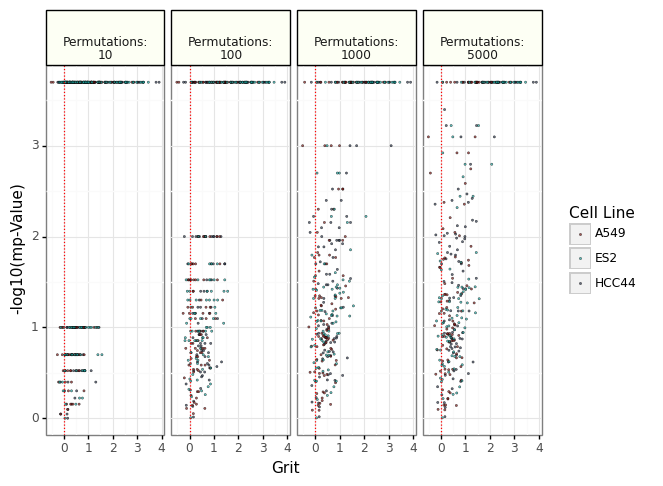

<ggplot: (396759815)>

In [6]:
cell_line_colors = {
  "A549": "#861613",
  "ES2": "#1CADA8",
  "HCC44": "#2A364D"
}

def col_func(s):
    return f"Permutations:\n{s}\n"

mp_value_comparison_gg = (
    gg.ggplot(combined_df.dropna(), gg.aes(x="grit", y="mp_value_neglog"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=0.7, stroke=0.2, alpha=0.7)
    + gg.geom_vline(xintercept=0, linetype="dotted", color="red")
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.xlab("Grit")
    + gg.ylab("-log10(mp-Value)")
    + gg.facet_wrap("~num_permutations", ncol=4, labeller=gg.labeller(cols=col_func))
    + gg.theme_bw()
    + gg.theme(strip_background=gg.element_rect(color="black", height=0.15, fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_mpvalue_comparison.png")
mp_value_comparison_gg.save(output_file, dpi=500, height=3, width=6.5)

mp_value_comparison_gg